In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pickle
import os
import mlflow
import mlflow.sklearn

import joblib

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
# Importing Important Libraries

import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
%matplotlib inline

In [5]:

import configparser
path_root="/home/cdsw"
USER_PREFIX='jvp'

config = configparser.ConfigParser()
config.read(f"{path_root}/parameters.conf")
data_lake_name=config.get("general","data_lake_name")
s3BucketName=config.get("general","s3BucketName")
train_tablename=config.get("general","train_tablename")
test_tablename=config.get("general","test_tablename")
experimentName = f"{USER_PREFIX}_{config.get('general','experimentName')}"

database =f"{USER_PREFIX}_{config.get('general','database')}"
srcdir=s3BucketName

In [6]:
# Click on the Data icon at the top of the window and click the "Spark Data Lake" button
# click on the copy code button and paste the contents below.

import cml.data_v1 as cmldata

# Sample in-code customization of spark configurations
#from pyspark import SparkContext
#SparkContext.setSystemProperty('spark.executor.cores', '1')
#SparkContext.setSystemProperty('spark.executor.memory', '2g')

CONNECTION_NAME = "jqrhv9chljtm"
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()



Setting spark.hadoop.yarn.resourcemanager.principal to csso_ozarate


Spark Application Id:spark-application-1727750301642


Hive Session ID = c38ad63f-6a94-41f4-b97e-767eaf5057db


+------------------+
|         namespace|
+------------------+
|           default|
|information_schema|
| jvp_cc_lead_model|
| ofz_cc_lead_model|
|               sys|
+------------------+



In [7]:
from __future__ import print_function
import os
import sys
from pyspark.sql import SparkSession
import time

In [8]:
spark = (
  SparkSession.builder.appName("CCLead-Data-Loader")
  .config("spark.sql.hive.hwc.execution.mode", "spark")
  .config("spark.sql.extensions", "com.qubole.spark.hiveacid.HiveAcidAutoConvertExtension, org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
  .config("spark.sql.catalog.spark_catalog.type", "hive")
  .config("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog")
  .config("spark.yarn.access.hadoopFileSystems", data_lake_name)
  .config("spark.hadoop.iceberg.engine.hive.enabled", "true")
  .config("spark.jars", "/opt/spark/optional-lib/iceberg-spark-runtime.jar")
  .getOrCreate()
  )



In [9]:
# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()
spark.sql(f"SELECT * FROM {database}.{train_tablename}.snapshots").show();

+------------------+
|         namespace|
+------------------+
|           default|
|information_schema|
| jvp_cc_lead_model|
| ofz_cc_lead_model|
|               sys|
+------------------+



+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|        committed_at|        snapshot_id|          parent_id|operation|       manifest_list|             summary|
+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|2024-09-25 17:58:...|7358846949846510102|               null|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:01:...|  21885554618766449|7358846949846510102|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:02:...|3253701813602397880|  21885554618766449|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:03:...|6254399732127111263|3253701813602397880|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
|2024-09-25 18:03:...|8629958596460495146|6254399732127111263|   append|s3a://jqrhv9chljt...|{spark.app.id -> ...|
+--------------------+-------------------+-------------------+---------+--------

In [10]:
# Pick the last snapshot_id on the list above and replace the 9999999999999999999. 
first_snapshot=8629958596460495146

In [11]:
train = spark.read\
    .option("snapshot-id", first_snapshot)\
    .format("iceberg")\
    .load(f"{database}.{train_tablename}").toPandas()
    # show the number of rows - should be 2449
train.shape[0]

245725

In [12]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,9RC4RMFI,Male,30,RG279,Self_Employed,X1,31,No,533759,No,0
1,LJ2UOGQP,Female,26,RG280,Salaried,X1,14,Yes,731811,No,0
2,MJCHTWFV,Male,26,RG267,Other,X1,26,Yes,475687,No,0
3,GXCCJKBS,Female,48,RG257,Self_Employed,X3,97,None,510210,No,1
4,GJCJQAKF,Female,30,RG279,Other,X1,15,No,453677,Yes,0


In [13]:
train.shape

(245725, 11)

In [14]:
test = spark.read\
    .format("iceberg")\
    .load(f"{database}.{test_tablename}").toPandas()
    # show the number of rows - should be 2449
test.shape[0]

105312

In [15]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,None,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [16]:
test.shape

(105312, 10)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int32 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int32 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int32 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int32 
dtypes: int32(4), object(7)
memory usage: 16.9+ MB


*The above information shows that there are nine features to predict the customer's interests in the recommended credit cards.*

*In train dataset there are 245725 observations and 9 features and 1 target column.*

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int32 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int32 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int32 
 9   Is_Active            105312 non-null  object
dtypes: int32(3), object(7)
memory usage: 6.8+ MB


*The test dataset contains 105312 obsevations and 9 features.*

In [19]:
# Let's see a statistical summary of the numerical columns in the train and test dataset.

train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


***The above summary shows that the average age of the customers who are eligible to take credit cards is 43 and the minimum age is 23 and the maximum age is 85.***

***Vintage is how long the eligible customers have been on the bank records.The average is 3 year 8 months and the minimum is 7 months, the maximum year is 11 years(135 months)***

In [20]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


## *Data Preprocessing*

In [21]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,9RC4RMFI,Male,30,RG279,Self_Employed,X1,31,No,533759,No,0
1,LJ2UOGQP,Female,26,RG280,Salaried,X1,14,Yes,731811,No,0
2,MJCHTWFV,Male,26,RG267,Other,X1,26,Yes,475687,No,0
3,GXCCJKBS,Female,48,RG257,Self_Employed,X3,97,None,510210,No,1
4,GJCJQAKF,Female,30,RG279,Other,X1,15,No,453677,Yes,0


In [22]:
# Replacing null values with 'Not Sure' for both train and test sets. Its al together creating new class

train['Credit_Product'] = train['Credit_Product'].fillna("Not Sure")
test['Credit_Product'] = test['Credit_Product'].fillna("Not Sure")
train[train['Credit_Product'] == 'Not Sure'].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
3,GXCCJKBS,Female,48,RG257,Self_Employed,X3,97,Not Sure,510210,No,1
10,6MOVUGLK,Male,56,RG254,Self_Employed,X2,93,Not Sure,1085114,No,1
11,FKDFDSBE,Male,53,RG284,Other,X2,74,Not Sure,1877766,No,1
16,MPRDXYWV,Male,67,RG284,Other,X1,44,Not Sure,3122609,No,1
33,96DNANHR,Male,32,RG268,Salaried,X1,15,Not Sure,662275,No,1


In [23]:
# Storing target value in 'Target' attribute for further usage

Target = pd.DataFrame(train['Is_Lead'])

In [24]:
# Dropping unwanted columns 

train = train.drop(['Is_Lead', 'ID'], axis = 1)
test = test.drop(['ID'], axis = 1)

print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (245725, 9)
Shape of test data: (105312, 9)


In [25]:
# Concat both sets to data file

data = pd.concat([train, test])
data.shape

(351037, 9)

In [26]:
# Trying to reduce skewnees by applying some operators 

data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance'])

data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Male,30,RG279,Self_Employed,X1,31,No,13.187700,No
1,Female,26,RG280,Salaried,X1,14,Yes,13.503278,No
2,Male,26,RG267,Other,X1,26,Yes,13.072515,No
3,Female,48,RG257,Self_Employed,X3,97,Not Sure,13.142578,No
4,Female,30,RG279,Other,X1,15,No,13.025141,Yes


In [27]:
## *Getting numeric and categorical columns*

data_num_cols = data._get_numeric_data().columns 
data_cat_cols = data.columns.difference(data_num_cols)
print("Numeric columns: ", data_num_cols)
print()
print("Categorical columns: ", data_cat_cols)

with open('data/data_num_cols.pkl', 'wb') as file:
    pickle.dump(data_num_cols, file)

with open('data/data_cat_cols.pkl', 'wb') as file:
    pickle.dump(data_cat_cols, file)
    

Numeric columns:  Index(['Age', 'Vintage', 'Avg_Account_Balance'], dtype='object')

Categorical columns:  Index(['Channel_Code', 'Credit_Product', 'Gender', 'Is_Active', 'Occupation',
       'Region_Code'],
      dtype='object')


In [28]:
#Separating both numeric and categorical data from set

data_num_data = data.loc[:, data_num_cols]
data_cat_data = data.loc[:, data_cat_cols]

print("Shape of num data:", data_num_data.shape)
print("Shape of cat data:", data_cat_data.shape)

Shape of num data: (351037, 3)
Shape of cat data: (351037, 6)


In [29]:
type(data_num_data)

pandas.core.frame.DataFrame

In [30]:
### Using StandardScaler to scale the data

from sklearn import preprocessing
s_scaler = preprocessing.StandardScaler()
data_num_data_s = s_scaler.fit_transform(data_num_data)

data_num_data_s = pd.DataFrame(data_num_data_s, columns = data_num_cols)

####

# Save the scaler
with open('data/standardscaler.pkl', 'wb') as file:
    pickle.dump(s_scaler, file)
    
#####


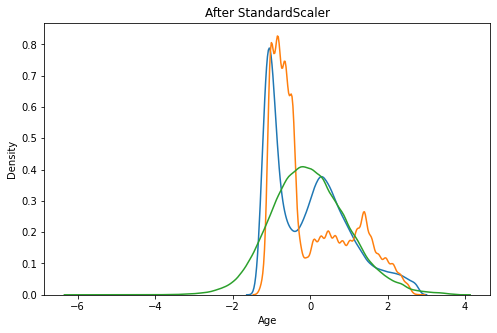

In [31]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After StandardScaler')

sns.kdeplot(data_num_data_s['Age'], ax=ax1)
sns.kdeplot(data_num_data_s['Vintage'], ax=ax1)
sns.kdeplot(data_num_data_s['Avg_Account_Balance'], ax=ax1);

***Handle Categorical Variable using One hot Encoder***

In [32]:
data_cat_data.head()

,Channel_Code,Credit_Product,Gender,Is_Active,Occupation,Region_Code
0,X1,No,Male,No,Self_Employed,RG279
1,X1,Yes,Female,No,Salaried,RG280
2,X1,Yes,Male,No,Other,RG267
3,X3,Not Sure,Female,No,Self_Employed,RG257
4,X1,No,Female,Yes,Other,RG279


### One hot encoding

In [33]:
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')

ohefit = enc.fit(data_cat_data)

#joblib.dump(ohefit, './data/ohefit.save')

# Save the scaler
with open('data/onehotenc.pkl', 'wb') as file:
    pickle.dump(ohefit, file)


In [34]:
data_cat_data_s = enc.fit_transform(data_cat_data)

In [35]:
#data_cat_data_s = pd.concat([df,ohetransform],axis = 1).drop(columns= ['link', 'location'])


#data_cat_data = data_cat_data.apply(LabelEncoder().fit_transform)
#data_cat_data_s = data_cat_data.apply(labelencoder.fit_transform)



# # Save the encoder
# with open('data/labelencoder.pkl', 'wb') as file:
#     pickle.dump(labelencoder, file)


In [36]:
data_cat_data_s.head()

,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_Not Sure,Credit_Product_Yes,Gender_Female,Gender_Male,Is_Active_No,...,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Storing cleaned data into 'data_new'

data_num_data_s.reset_index(drop=True, inplace=True)
data_cat_data_s.reset_index(drop=True, inplace=True)
#df = pd.concat([df1, df2], axis=1)
data_new = pd.concat([data_num_data_s, data_cat_data_s], axis = 1)

In [38]:
Target

,Is_Lead
0,0
1,0
2,0
3,1
4,0
...,...
245720,0
245721,0
245722,1
245723,0


In [39]:
# Splitting back the data into train and test

train_new = data_new.iloc[:245725,]
test_new = data_new.iloc[245726:,]

print("Shape of train data:", train_new.shape)
print("Shape of test data:", test_new.shape)

Shape of train data: (245725, 53)
Shape of test data: (105311, 53)


In [40]:
#train_new.isnull().sum()

In [41]:
train_new.dtypes

Age                         float64
Vintage                     float64
Avg_Account_Balance         float64
Channel_Code_X1             float64
Channel_Code_X2             float64
Channel_Code_X3             float64
Channel_Code_X4             float64
Credit_Product_No           float64
Credit_Product_Not Sure     float64
Credit_Product_Yes          float64
Gender_Female               float64
Gender_Male                 float64
Is_Active_No                float64
Is_Active_Yes               float64
Occupation_Entrepreneur     float64
Occupation_Other            float64
Occupation_Salaried         float64
Occupation_Self_Employed    float64
Region_Code_RG250           float64
Region_Code_RG251           float64
Region_Code_RG252           float64
Region_Code_RG253           float64
Region_Code_RG254           float64
Region_Code_RG255           float64
Region_Code_RG256           float64
Region_Code_RG257           float64
Region_Code_RG258           float64
Region_Code_RG259           

In [42]:
train_new.head

<bound method NDFrame.head of              Age   Vintage  Avg_Account_Balance  Channel_Code_X1  \
0      -0.933890 -0.492564            -0.880871              1.0   
1      -1.203397 -1.018404            -0.372265              1.0   
2      -1.203397 -0.647223            -1.066509              1.0   
3       0.278892  1.548930            -0.953592              0.0   
4      -0.933890 -0.987472            -1.142861              1.0   
...          ...       ...                  ...              ...   
245720  1.693804  1.177749             1.126223              0.0   
245721 -0.664383 -0.678155            -1.078951              0.0   
245722  0.548399  1.394271            -0.203981              0.0   
245723 -1.068644 -0.492564             0.166478              1.0   
245724  0.952659  1.920111             0.048589              0.0   

        Channel_Code_X2  Channel_Code_X3  Channel_Code_X4  Credit_Product_No  \
0                   0.0              0.0              0.0                

In [43]:
# Split the dataset into training and testing set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new,Target,test_size=0.2,random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196580, 53), (49145, 53), (196580, 1), (49145, 1))

In [45]:
row_dict = X_train.iloc[1].to_dict()
json_row = pd.Series(row_dict).to_json()

print(json_row)

row_dict = X_test.iloc[1].to_dict()
json_row = pd.Series(row_dict).to_json()

print(json_row)


row_dict = y_train.iloc[1].to_dict()
json_row = pd.Series(row_dict).to_json()

print(json_row)


row_dict = y_test.iloc[1].to_dict()
json_row = pd.Series(row_dict).to_json()

print(json_row)

{"Age":-1.2707741093,"Vintage":-1.049335718,"Avg_Account_Balance":-0.9539870591,"Channel_Code_X1":1.0,"Channel_Code_X2":0.0,"Channel_Code_X3":0.0,"Channel_Code_X4":0.0,"Credit_Product_No":1.0,"Credit_Product_Not Sure":0.0,"Credit_Product_Yes":0.0,"Gender_Female":0.0,"Gender_Male":1.0,"Is_Active_No":0.0,"Is_Active_Yes":1.0,"Occupation_Entrepreneur":0.0,"Occupation_Other":0.0,"Occupation_Salaried":1.0,"Occupation_Self_Employed":0.0,"Region_Code_RG250":0.0,"Region_Code_RG251":0.0,"Region_Code_RG252":0.0,"Region_Code_RG253":0.0,"Region_Code_RG254":0.0,"Region_Code_RG255":0.0,"Region_Code_RG256":0.0,"Region_Code_RG257":0.0,"Region_Code_RG258":0.0,"Region_Code_RG259":0.0,"Region_Code_RG260":0.0,"Region_Code_RG261":0.0,"Region_Code_RG262":0.0,"Region_Code_RG263":0.0,"Region_Code_RG264":1.0,"Region_Code_RG265":0.0,"Region_Code_RG266":0.0,"Region_Code_RG267":0.0,"Region_Code_RG268":0.0,"Region_Code_RG269":0.0,"Region_Code_RG270":0.0,"Region_Code_RG271":0.0,"Region_Code_RG272":0.0,"Region_Code_R

## *Model Building*

In [46]:
# Now Ensemble Techniques (Bagging and Boosting)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [47]:
# Evaluate Model Performance

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay, auc

In [48]:
# import mlflow
# import mlflow.sklearn
# mlflow.set_experiment(experimentName)

In [49]:
# mlflow.start_run()

In [50]:
# Fitting random forest classifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/home/cdsw/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [51]:
rf_pred = rf.predict(X_test)

In [52]:
rf_auc = roc_auc_score(y_test, rf_pred)

In [53]:
rf_auc = roc_auc_score(y_test, rf_pred)
rf_auc

0.7546898232743511

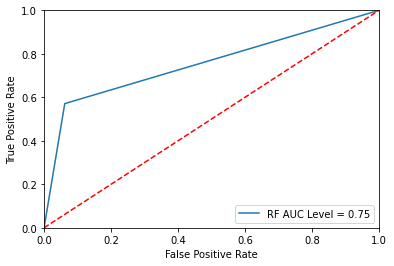

In [54]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, rf_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()



In [55]:

# mlflow.log_param("iceberg_snapshot",first_snapshot)
# mlflow.log_param("feature_table",train_tablename)
# mlflow.log_param("classifier","RandomForestClassifier")
# mlflow.log_metric("auc", rf_auc)
# mlflow.log_figure(fig, "rf_auc.png")
# mlflow.sklearn.log_model(rf, "rf_model")
  

In [56]:

# mlflow.end_run()

** Save File **

In [57]:
with open('models_from_code/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

### Stop here 9-30-24

In [47]:
# Start a new entry
#mlflow.start_run()

<ActiveRun: >

In [48]:
# Fitting XGB Classifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
xgb_pred = rf.predict(X_test)

xgb_auc = roc_auc_score(y_test, rf_pred)
xgb_auc

0.7579946541142314

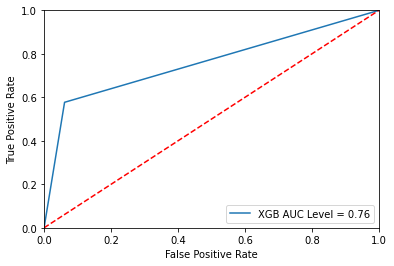

In [50]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, xgb_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='XGB AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()


In [51]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","XGBClassifier")
mlflow.log_metric("auc", xgb_auc)
mlflow.log_figure(fig, "xgb_auc.png")
mlflow.sklearn.log_model(xgb, "xgb_model")
  

In [52]:

mlflow.end_run()

## *Model Performance Improvement*

In [53]:
# Start a new entry
mlflow.start_run()

<ActiveRun: >

In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(train_new,Target)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [ ]:
# Fitting random forest classifier on balanced dataset

rfb = RandomForestClassifier()
rfb.fit(X_train, y_train)

/home/cdsw/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
rfb_pred = rfb.predict(X_test)

rfb_auc = roc_auc_score(y_test, rfb_pred)
rfb_auc

In [ ]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, rfb_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()


In [ ]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","RFBClassifier")
mlflow.log_metric("auc", rfb_auc)
mlflow.log_figure(fig, "rfb_auc.png")
mlflow.sklearn.log_model(rfb, "rfb_model")


In [ ]:

mlflow.end_run()

In [ ]:
# Start a new entry
mlflow.start_run()

In [ ]:
# Fitting LightGBM on balance data

from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

In [ ]:
lgb_predict = lgb.predict(X_test)

In [ ]:
lgb_auc_score = roc_auc_score(y_test, lgb_predict)
lgb_auc_score

In [ ]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, lgb_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='RF AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#save the plot as a variable
fig = plt.gcf()

plt.show()

In [ ]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","LGBClassifier")
mlflow.log_metric("auc", lgb_auc_score)
mlflow.log_figure(fig, "lgb_auc.png")
mlflow.sklearn.log_model(lgb, "lgb_model")

In [ ]:

mlflow.end_run()

In [ ]:
# Start a new entry
mlflow.start_run()

In [ ]:
# Fitting XGB Classifier on balanced dataset

model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
xgb_predict = model.predict(X_test)

In [ ]:
xgb_auc_score = roc_auc_score(y_test, xgb_predict)
xgb_auc_score

In [ ]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, xgb_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
mlflow.log_param("iceberg_snapshot",first_snapshot)
mlflow.log_param("feature_table",train_tablename)
mlflow.log_param("classifier","XGBBClassifier")
mlflow.log_metric("auc", xgb_auc_score)
mlflow.log_figure(fig, "xgb_auc.png")
mlflow.sklearn.log_model(model, "xgb_model")

In [ ]:

mlflow.end_run()